In [1]:
##import libraries
import time
import gc
import numpy as np
import matplotlib.pyplot as plt

import clip
import torch
from PIL import Image
from torch.utils.data import DataLoader
from utils.custom_dataset import CustomDataset

##define device
device = "cuda" if torch.cuda.is_available() else "cpu"

##define paths
basepath = "C:/Users/vanth/OneDrive/Desktop/JHUClasses/data/intel_dataset/"
trainpath = basepath + 'seg_train/'
valpath = basepath + 'seg_test/'

In [2]:
##instantiate custom datasets
train_data = CustomDataset(trainpath, 'train set')
val_data = CustomDataset(valpath, 'valid set')

Getting Files from Disk.: 6it [00:00, 486.48it/s]



Dataset Initialized with Tag:  train set
Unique number of classes:  6
Classes:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Dataset Size:  14034




Getting Files from Disk.: 6it [00:00, 2000.62it/s]


Dataset Initialized with Tag:  valid set
Unique number of classes:  6
Classes:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Dataset Size:  3000




In [3]:
##instantiate data loaders
trainloader = DataLoader(train_data, batch_size=1, collate_fn=train_data.collate_fn,
                          shuffle=True)

valloader = DataLoader(val_data, batch_size=1, collate_fn=val_data.collate_fn,
                        shuffle=True)

##sanity check
images, targets = next(iter(trainloader))
images, targets = next(iter(valloader))

print('Num Images: ', len(images))
print('Num Targets: ', len(targets))
print('Shape of Image ', images[0].shape)

Num Images:  1
Num Targets:  1
Shape of Image  (150, 150, 3)


## Zero Shot Prediction


Top predictions:
          street: 72.27%
       buildings: 27.44%
        mountain: 0.25%
             sea: 0.02%
          forest: 0.01%
         glacier: 0.00%




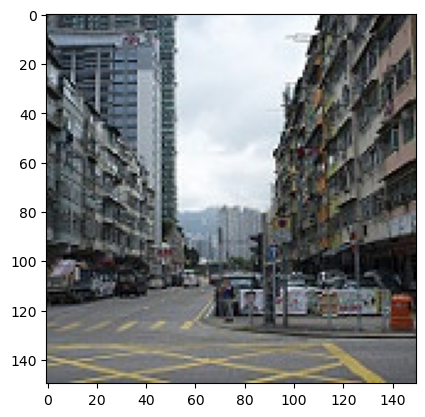

In [4]:
##inference
model, preprocess = clip.load('ViT-B/32', device)

##show image
plt.imshow(images[0])

##put image on device
image = Image.fromarray(images[0].astype('uint8'))
# image = Image.fromarray(images[0])
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in train_data.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 10 most similar labels for the image
num_top_picks = 6
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(num_top_picks)

# Print the result
print("\nTop predictions:")
for value, index in zip(values, indices):
    print(f"{train_data.classes[index]:>16s}: {100 * value.item():.2f}%")
print('\n')

## Linear Probe Evaluation

In [5]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

##instantiate custom datasets and add transforms
train_data = CustomDataset(trainpath, 'train set', transforms=preprocess)
val_data = CustomDataset(valpath, 'valid set', transforms=preprocess)

Getting Files from Disk.: 6it [00:00, 461.32it/s]



Dataset Initialized with Tag:  train set
Unique number of classes:  6
Classes:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Dataset Size:  14034




Getting Files from Disk.: 6it [00:00, 1219.16it/s]


Dataset Initialized with Tag:  valid set
Unique number of classes:  6
Classes:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Dataset Size:  3000




In [6]:
from tqdm import tqdm

def get_features(dset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train_data)
test_features, test_labels = get_features(val_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:27<00:00,  1.11it/s]


In [8]:
from sklearn.linear_model import LogisticRegression

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 95.233
